### **Идея**

В этом проекте я хочу проанализировать имена в России (в особенности, в Москве), проверить некоторые гипотезы, такие, как:
1. Цикличность имен - наверное, многие сталкивались со случаями, что детей называют в честь их бабушек и т.д.?)
2. Связь популярности имен с некоторыми событиями - я нашла много сайтов, которые говорят, что популярность имен зависит от популярности фильмов или от значимых событий - это и надо будет проверить.
3. Чем ближе регионы России, тем более схожие у них популярные имена.
4. Посмотрим на корреляции популряности разных имен - когда одни имена становятся популярными, другие теряют свою популряность?
5. Посмотрим, насколько имена в Москве следуют за "трендами" имен по всему миру.
6. Ну и просто посомотрим самые популярные имена в Москве по годам и сделаем из этого некоторые выводы)



## **Шаг 1**

Скачаем все нужные библиотеки и импортируем их.

In [129]:
import pandas as pd
import requests
import re
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import sqlite3
import requests
from bs4 import BeautifulSoup
import seaborn as sns
from sklearn.linear_model import LinearRegression
import networkx as nx
from mtranslate import translate
import streamlit as st
from pyngrok import ngrok
import subprocess
import time
import openpyxl
import io
import warnings

## **Шаг 2**

Теперь скачаем нужные данные из интернета. Я нашла их на двух сайтах:

1. [Сбор данных из двух баз Larix и Cedrus](https://github.com/meule/names/tree/master) - тут лежат данные до 2000-ых годов
2. [Данные по именам из портала открытых данных правительства Москвы](https://data.mos.ru/opendata?searchString=имена&activeStatus=true&sorting=byNameCatalog-ASC) - тут лежат недавние данные, после 2000-ых

Все эти данные по именам *в Москве*!


In [118]:
#ссылка на гитхаб с данными до 2000-ых годов

url = "https://raw.githubusercontent.com/meule/names/master/names.csv"

df = pd.read_csv(url)

#переводим данные в проценты  = количество имен/полное количество имен в данном году

df['num'] = df['num'] / df['total']*100

df.drop('total', axis=1, inplace=True)

# делаем отдельную data frame мужских и женких имен

df_female = df[df['sex'] == 'Ж'].copy()

df_male = df[df['sex'] == 'М'].copy()

df_female.drop('sex', axis=1, inplace=True)
df_male.drop('sex', axis=1, inplace=True)

Считываем данные с сайта data.mos.ru через API:

In [119]:
# берем ссылки и ключ
url = 'https://apidata.mos.ru/v1/datasets/2009/rows'
api_key = '2f1e3836-29b9-4c58-809d-73a5db3c3c4a'
top = 500  # максимальное количество записей за раз по документации
skip = 0

params = {
    'api_key': api_key,
    '$top': top,
    '$skip': skip
}

w_data = pd.DataFrame()

# считываем по 500 строк из-за ограничения в документации
while True:
    # берем 500 строк
    response = requests.get(url, params=params)
    data = response.json()

    # делаем из этого data frame
    df = pd.json_normalize(data)

    # закидываем в общий data frame
    w_data = pd.concat([w_data, df], ignore_index=True)
    
    if len(df) < top:  # если получено меньше 500 записей, значит это последний набор данных
        break
    # обновляем параметра для сдвига данных
    params['$skip'] += top

# убираем ненужные ячейки
w_data.drop('Cells.global_id', axis=1, inplace=True)
w_data.drop('Number', axis=1, inplace=True)
w_data.columns = ['global_id', 'ID', 'Name', 'NumberOfPersons', 'Year', 'Month']

# можно посмотреть на результаты
w_data.head()


,global_id,ID,Name,NumberOfPersons,Year,Month
0,37750254,1,Мария,252,2015,январь
1,37750255,2,Анастасия,224,2015,январь
2,37750256,3,Анна,190,2015,январь
3,37750257,4,Варвара,190,2015,январь
4,37750258,5,Виктория,186,2015,январь


In [120]:
# такие же действия проводим для второго датасета
# берем ссылки и ключ
url = 'https://apidata.mos.ru/v1/datasets/2011/rows'
api_key = '2f1e3836-29b9-4c58-809d-73a5db3c3c4a'
top = 500  # максимальное количество записей за раз по документации
skip = 0

params = {
    'api_key': api_key,
    '$top': top,
    '$skip': skip
}

m_data = pd.DataFrame()

# считываем по 500 строк из-за ограничения в документации
while True:
    # берем 500 строк
    response = requests.get(url, params=params)
    data = response.json()

    # делаем из этого data frame
    df = pd.json_normalize(data)

    # закидываем в общий data frame
    m_data = pd.concat([m_data, df], ignore_index=True)
    
    if len(df) < top:  # если получено меньше 500 записей, значит это последний набор данных
        break
    # обновляем параметра для сдвига данных
    params['$skip'] += top

# убираем ненужные ячейки
m_data.drop('Cells.global_id', axis=1, inplace=True)
m_data.drop('Number', axis=1, inplace=True)
m_data.columns = ['global_id', 'ID', 'Name', 'NumberOfPersons', 'Year', 'Month']

# можно посмотреть на результаты
m_data.head()


,global_id,ID,Name,NumberOfPersons,Year,Month
0,37750243,1,Александр,253,2015,январь
1,37750244,2,Михаил,247,2015,январь
2,37750245,3,Иван,226,2015,январь
3,37750246,4,Максим,208,2015,январь
4,37750247,5,Артём,190,2015,январь


Данные считаны! Теперь приведем их к нужному формату.

In [121]:
# получаем последние данные по именам по второй ссылке
df_women = w_data.copy()
df_men = m_data.copy()

# переводим данные из строк в числа
df_women["NumberOfPersons"] = pd.to_numeric(df_women["NumberOfPersons"], errors='coerce').fillna(0).astype(int)

# найдем суммарное количество имен для каждого года
names_per_year = df_women.groupby("Year")["NumberOfPersons"].sum().reset_index()
names_per_year.columns = ["year", "count_names"]

# группируем данные по имени и году, затем считаем сумму имен для каждой группы
df_sumf = df_women.groupby(["Name", "Year"])["NumberOfPersons"].sum().reset_index()
df_sumf.columns = ['name', 'year', 'num']

# объединяем с данными о количестве имен в каждом году
df_sumf = pd.merge(df_sumf, names_per_year, on='year')

# находим процентое соотношение количества одного имени к общему количеству
df_sumf['num'] = df_sumf['num'] / df_sumf['count_names']*100

# Удаляем временный столбец count_names
df_sumf.drop('count_names', axis=1, inplace=True)

# делаем то же самое для мужских имен

df_men["NumberOfPersons"] = pd.to_numeric(df_men["NumberOfPersons"], errors='coerce').fillna(0).astype(int)
names_per_year = df_men.groupby("Year")["NumberOfPersons"].sum().reset_index()
names_per_year.columns = ["year", "count_names"]
df_summ = df_men.groupby(["Name", "Year"])["NumberOfPersons"].sum().reset_index()
df_summ.columns = ['name', 'year', 'num']
df_summ = pd.merge(df_summ, names_per_year, on='year')
df_summ['num'] = df_summ['num'] / df_summ['count_names']*100
df_summ.drop('count_names', axis=1, inplace=True)

In [122]:
# соединяю данные по двум ссылкам для женщин, чтобы получить единую data frame

merged_df_female = pd.concat([df_female, df_sumf], ignore_index=True)
merged_df_female['name'] = merged_df_female['name'].apply(lambda x: x.capitalize() if x.isupper() else x.lower().capitalize())

# прошу большое прощения у всех людей с именем София и Софья, но я хочу учитывать это, как одно имя
merged_df_female['name'] = merged_df_female['name'].replace('София, софья', 'София')
merged_df_female['name'] = merged_df_female['name'].replace('Софья', 'София')
merged_df_female = merged_df_female.groupby(['name', 'year'], as_index=False).agg({'num': 'sum'})

#ниже можно посмотреть состав таблицы
print(merged_df_female.head())

    name  year       num
0  Абида  1909  0.004323
1  Абида  1910  0.002380
2  Абида  1912  0.002166
3  Абида  1918  0.002923
4  Абида  1925  0.000631


In [123]:
# соединяю данные по двум ссылкам для мужчин, чтобы получить единую data frame
merged_df_male = pd.concat([df_male, df_summ], ignore_index=True)
merged_df_male['name'] = merged_df_male['name'].apply(lambda x: x.capitalize() if x.isupper() else x.lower().capitalize())

# Аарон и Арон одно и то же имя, поэтому их заменяю
merged_df_male['name'] = merged_df_male['name'].replace('Аарон', 'Арон')
merged_df_male = merged_df_male.groupby(['name', 'year'], as_index=False).agg({'num': 'sum'})
print(merged_df_male.head())

     name  year       num
0  Абакар  1930  0.000506
1  Абакар  1931  0.000541
2  Абакар  1938  0.000351
3  Абакар  1940  0.000413
4  Абакар  1941  0.000415


## **Шаг 3**

Для начала сделем простой анализ имен:

- Во-первых, мне интересно, сколько славянских мужских имен в этой таблице, чтобы посмотреть, правильно ли вылились данные за 20 век. Для этого я отбираю эти имена по стандартным составляющим, как Люб, Мир, Слав и т.д. Также я убираю некоторые шипищие, так как они свойственны именам других национальностей.
-Во-вторых, просто давно было интересно, сколько женских имен из 10 букв есть в Москве (такое, как мое имя - Александра). Вдруг мама только меня обрекла на страдание писать свое бесконечное имя? (Я просто всю жизнь жалуюсь)

In [124]:
# Создаем DataFrame из уникальных имен
name_df = pd.DataFrame({'name': merged_df_male['name'].unique()})

names_slavic = name_df[name_df['name'].str.match(r'^(?=.*[Бб]ог|[Сс]лав|[Мм]ир|[Сс]вет|[Лл]юб|Яр)(?!.*[ХхЙйШшЩщЗзЖж])[А-Яа-я]+$')]

print(*list(names_slavic['name']))
print(len(list(names_slavic['name'])))


Богдан Богомед Любим Любомир Мир Мирага Мирас Миргалиян Мириан Мирлан Мирон Мирослав Мирча Светислав Светлан Светослав Славик Славянин Яромир Ярополк Ярослав Ярост Ярула
23


Получается, можем заметить, что в 20 веке еще называли детей такими именами, но если посмотреть данные в конце этого проекта, то можно заметить, что этими именами часто называли только в начале 20 века, что, думаю, сходится с реальными данными. То есть с таблицей все нормально.

In [125]:
letters = 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ'
d = dict()

# Создаем DataFrame из уникальных имен
name_df = pd.DataFrame({'name': merged_df_female['name'].unique()})

for item in letters:
  # Извлечение имен, начинающихся на букву "А" и содержащих 10 букв
  names_starting_with_item_and_10_letters = name_df[name_df['name'].str.contains(r'^' + item, case=False) & name_df['name'].str.match(r'^[А-Яа-я]{10}$', case=False)]
  d[item] = list(names_starting_with_item_and_10_letters['name'])

for key,value in d.items():
  if len(value)!=0:
    print(f"Имена, начинающиеся на букву '{key}' и содержащие 10 букв: {', '.join(value)}")


Имена, начинающиеся на букву 'А' и содержащие 10 букв: Александра, Алерентина, Альбертина, Антуанетта, Аполинария, Асмиральда, Асхабжамял
Имена, начинающиеся на букву 'Б' и содержащие 10 букв: Бартоломеу, Бронгильда, Бронислава, Брунгильда
Имена, начинающиеся на букву 'В' и содержащие 10 букв: Валентинаа, Великонида, Викторория, Владислава
Имена, начинающиеся на букву 'Г' и содержащие 10 букв: Гальдигана, Гельчачаке, Гильджиган, Гольнаберг, Градислава, Гульбустан, Гульмайсер, Гульнадира, Гульназира, Гульшагара, Гюльджаган
Имена, начинающиеся на букву 'Е' и содержащие 10 букв: Евангелина, Еванжелина, Евфросинья, Елизаветта
Имена, начинающиеся на букву 'З' и содержащие 10 букв: Зайфабьяна, Златослава
Имена, начинающиеся на букву 'К' и содержащие 10 букв: Казьмерина, Калествина, Капиталина, Капитолина, Констанция, Красномира
Имена, начинающиеся на букву 'М' и содержащие 10 букв: Магальсема, Магисарвар, Мадинабону, Манзурахан, Маргаритта, Марионелла, Марсельеза, Матлубахан, Мвалентина, Мии

Ну, не одна я такая, но русских имен тут, конечно, маловато)

## **Шаг 4**

Теперь посмотрим самые популярные имена, рожденных за 2024 год девочек, и изобразим все это в виде круговой диаграммы, чтобы было все наглядно.

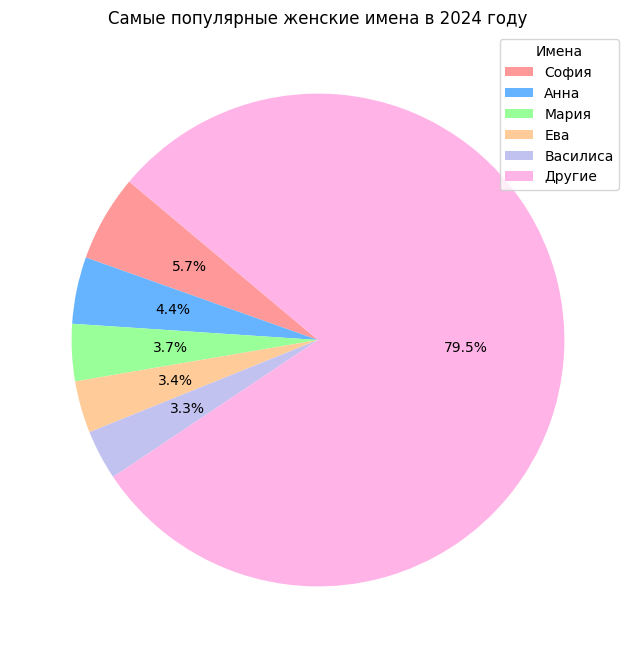

In [126]:
# фильтруем данные для 2024 года
df_2024 = merged_df_female[merged_df_female['year'] == 2024]

# сортируем по убыванию и берем топ-5 имен
top_names = df_2024.nlargest(5, 'num')

# суммируем остальные значения num, чтобы убрать их в другую категорию (не хочу создавать беспорядок)
other_num = df_2024.loc[~df_2024['name'].isin(top_names['name']), 'num'].sum()

# объединяем топ-5 имена с категорией Другие
other_names = pd.DataFrame({'name': ['Другие'], 'num': [other_num]})
top_names = pd.concat([top_names, other_names], ignore_index=True)

# делаю очень красивые цвета, чтобы было приятно смотреть
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6']

# строим круговую диаграмму
plt.figure(figsize=(8, 8))
plt.pie(top_names['num'], colors = colors, autopct='%1.1f%%', startangle=140)
plt.legend(top_names['name'], title="Имена", loc="best")
plt.title('Самые популярные женские имена в 2024 году')
plt.show()


Получается, мы можем заметить самые популярные женские имена за 2024 год - Софья, Анна, Мария, Ева, Василиса.

## **Шаг 5**

Теперь, чтобы все было наглядно, я хочу подвести статистику за десятилетия - так будет намного легче на все смотреть.

In [127]:
#делаю фукнцию, чтобы вытащить десятилетия
def get_decade(year):
    return str(int(year) // 10 * 10) + '-' + str(int(year) // 10 * 10 + 9)

# добавляю столбец с десятилетием
merged_df_female['decade'] = merged_df_female['year'].apply(get_decade)

# группирую данные по имени и десятилетию, затем считаю сумму для каждой группы
result_f = merged_df_female.groupby(['name', 'decade'])['num'].sum().reset_index()

# что получилось, можно посмотреть ниже
print(result_f.head())

# делаю такие же шаги для мужских имен
merged_df_male['decade'] = merged_df_male['year'].apply(get_decade)
result_m = merged_df_male.groupby(['name', 'decade'])['num'].sum().reset_index()

    name     decade       num
0  Абида  1900-1909  0.004323
1  Абида  1910-1919  0.007468
2  Абида  1920-1929  0.003305
3  Абида  1930-1939  0.001370
4  Абида  1940-1949  0.001018


In [130]:
warnings.filterwarnings("ignore")
# теперь для каждог десятилетия возьмем топ самых популярных имен и поместим в словарь
top_names_by_decade = result_f.groupby('decade').apply(lambda x: x.nlargest(10, 'num').reset_index(drop=True)).reset_index(drop=True)
result_f_dict = top_names_by_decade.groupby('decade')['name'].apply(list).to_dict()

# результат ниже
print(result_f_dict)

#делаем также для мужских имен
top_names_by_decade_m = result_m.groupby('decade', group_keys = False).apply(lambda x: x.nlargest(10, 'num')).reset_index(drop=True)
result_m_dict = top_names_by_decade_m.groupby('decade')['name'].apply(list).to_dict()

{'1890-1899': ['Мария', 'Анна', 'Екатерина', 'Елена', 'Евгения', 'Ольга', 'Евдокия', 'Матрена', 'София', 'Ревекка'], '1900-1909': ['Мария', 'Анна', 'Александра', 'Татьяна', 'Екатерина', 'Евдокия', 'Анастасия', 'Ольга', 'Елена', 'Клавдия'], '1910-1919': ['Мария', 'Анна', 'Александра', 'Клавдия', 'Татьяна', 'Екатерина', 'Анастасия', 'Евдокия', 'Вера', 'Ольга'], '1920-1929': ['Мария', 'Анна', 'Нина', 'Александра', 'Валентина', 'Лидия', 'Клавдия', 'Вера', 'Екатерина', 'Зинаида'], '1930-1939': ['Валентина', 'Нина', 'Галина', 'Мария', 'Лидия', 'Людмила', 'Тамара', 'Анна', 'Зинаида', 'Раиса'], '1940-1949': ['Валентина', 'Галина', 'Татьяна', 'Людмила', 'Нина', 'Лидия', 'Надежда', 'Тамара', 'Наталья', 'Любовь'], '1950-1959': ['Татьяна', 'Галина', 'Людмила', 'Елена', 'Наталья', 'Валентина', 'Надежда', 'Ольга', 'Ирина', 'Любовь'], '1960-1969': ['Елена', 'Татьяна', 'Ирина', 'Ольга', 'Светлана', 'Наталья', 'Марина', 'Галина', 'Людмила', 'Лариса'], '1970-1979': ['Елена', 'Наталья', 'Ольга', 'Татьяна

In [133]:
# собираем женские имена в data frame и выводим ее
df_female_decade = pd.DataFrame.from_dict(result_f_dict, orient='index')
df_female_decade = df_female_decade.transpose()
df_female_decade.index = range(1, 11)
df_female_decade.columns.name = 'Year'
print('\n Статистика по женским именам\n')
display(df_female_decade)

# выводим мужсские имена
df_male_decade = pd.DataFrame.from_dict(result_m_dict, orient='index')
df_male_decade = df_male_decade.transpose()
df_male_decade.index = range(1, 11)
df_male_decade.columns.name = 'Year'
print('\n Статистика по мужским именам\n')
display(df_male_decade)


 Статистика по женским именам



Year,1890-1899,1900-1909,1910-1919,1920-1929,1930-1939,1940-1949,1950-1959,1960-1969,1970-1979,1980-1989,1990-1999,2000-2009,2010-2019,2020-2029
1,Мария,Мария,Мария,Мария,Валентина,Валентина,Татьяна,Елена,Елена,Елена,Анастасия,Анастасия,София,София
2,Анна,Анна,Анна,Анна,Нина,Галина,Галина,Татьяна,Наталья,Екатерина,Анна,Мария,Мария,Анна
3,Екатерина,Александра,Александра,Нина,Галина,Татьяна,Людмила,Ирина,Ольга,Ольга,Екатерина,Анна,Анна,Мария
4,Елена,Татьяна,Клавдия,Александра,Мария,Людмила,Елена,Ольга,Татьяна,Анна,Мария,Дарья,Виктория,Ева
5,Евгения,Екатерина,Татьяна,Валентина,Лидия,Нина,Наталья,Светлана,Ирина,Наталья,Дарья,Екатерина,Алиса,Виктория
6,Ольга,Евдокия,Екатерина,Лидия,Людмила,Лидия,Валентина,Наталья,Светлана,Юлия,Юлия,Елизавета,Анастасия,Алиса
7,Евдокия,Анастасия,Анастасия,Клавдия,Тамара,Надежда,Надежда,Марина,Юлия,Татьяна,Ольга,София,Полина,Полина
8,Матрена,Ольга,Евдокия,Вера,Анна,Тамара,Ольга,Галина,Екатерина,Ирина,Александра,Полина,Елизавета,Варвара
9,София,Елена,Вера,Екатерина,Зинаида,Наталья,Ирина,Людмила,Марина,Мария,Елена,Виктория,Александра,Александра
10,Ревекка,Клавдия,Ольга,Зинаида,Раиса,Любовь,Любовь,Лариса,Анна,Светлана,Татьяна,Александра,Дарья,Елизавета



 Статистика по мужским именам



Year,1890-1899,1900-1909,1910-1919,1920-1929,1930-1939,1940-1949,1950-1959,1960-1969,1970-1979,1980-1989,1990-1999,2000-2009,2010-2019,2020-2029
1,Арон,Александр,Иван,Николай,Владимир,Владимир,Александр,Сергей,Сергей,Александр,Александр,Александр,Александр,Михаил
2,Алексей,Николай,Николай,Иван,Николай,Александр,Владимир,Александр,Александр,Сергей,Дмитрий,Иван,Михаил,Александр
3,Моисей,Иван,Александр,Владимир,Виктор,Виктор,Сергей,Андрей,Алексей,Алексей,Алексей,Никита,Максим,Максим
4,Виктор,Михаил,Василий,Александр,Анатолий,Николай,Николай,Владимир,Андрей,Дмитрий,Сергей,Максим,Артём,Лев
5,Николай,Владимир,Михаил,Василий,Юрий,Анатолий,Виктор,Игорь,Дмитрий,Андрей,Андрей,Дмитрий,Иван,Марк
6,Александр,Сергей,Алексей,Михаил,Александр,Юрий,Юрий,Алексей,Владимир,Евгений,Иван,Артем,Дмитрий,Артём
7,Иван,Василий,Сергей,Виктор,Иван,Валерий,Михаил,Юрий,Михаил,Михаил,Никита,Андрей,Кирилл,Иван
8,Август,Алексей,Владимир,Алексей,Борис,Михаил,Анатолий,Михаил,Игорь,Максим,Максим,Даниил,Андрей,Матвей
9,Иосиф,Виктор,Петр,Анатолий,Евгений,Евгений,Валерий,Олег,Олег,Владимир,Михаил,Алексей,Матвей,Дмитрий
10,Сергей,Петр,Павел,Сергей,Михаил,Вячеслав,Алексей,Дмитрий,Евгений,Павел,Артем,Михаил,Илья,Даниил


**Интересный факт:** Я где-то читала, что в 1960-ых при рождении ребенка спрашивали: У вас мальчик или Леночка? Как видно, это можно было спрашивать до 1990 года)

Я также подведу такие же данные по годам, а не по десятилетиям, но таблицу выводить не буду, так как она сюда не поместится))

In [134]:
# топ-10 женских имен по годам
top_names_by_year = merged_df_female.groupby('year').apply(lambda x: x.nlargest(10, 'num')).reset_index(drop=True)
result_female_year = top_names_by_year.groupby('year')['name'].apply(list).to_dict()
print(result_female_year)

# топ-20 мужских имен по годам
top_names_by_year_m = merged_df_male.groupby('year').apply(lambda x: x.nlargest(10, 'num')).reset_index(drop=True)
result_male_year = top_names_by_year_m.groupby('year')['name'].apply(list).to_dict()

{1891: ['Анна', 'Екатерина', 'Елена', 'Мария', 'Матрена', 'Ревекка', 'Роза'], 1892: ['Анна', 'Вера', 'Евгения', 'Зинаида', 'Клавдия', 'Клара', 'Лидия', 'Мария', 'Матрена', 'Миндля'], 1893: ['Двойра', 'Евдокия', 'Мария', 'Анна', 'Вероника', 'Евгения', 'Елена', 'Надежда', 'Ольга', 'Ревекка'], 1894: ['Анна', 'Мария', 'Ольга', 'Вера', 'Евгения', 'Любовь', 'Надежда', 'Александра', 'Анастасия', 'Валентина'], 1895: ['Мария', 'Анна', 'Любовь', 'Евгения', 'Марина', 'Татьяна', 'Вера', 'Евдокия', 'Екатерина', 'Елена'], 1896: ['Мария', 'Анна', 'Анастасия', 'София', 'Пелагея', 'Александра', 'Амалия', 'Ангелина', 'Евдокия', 'Елена'], 1897: ['Анна', 'Екатерина', 'Мария', 'Наталья', 'Вера', 'Евгения', 'Евдокия', 'Елена', 'Ирина', 'Ольга'], 1898: ['Анна', 'Мария', 'Пелагея', 'Татьяна', 'Анастасия', 'Евдокия', 'Екатерина', 'София', 'Елена', 'Клавдия'], 1899: ['Анна', 'Мария', 'Ольга', 'Татьяна', 'Александра', 'Вера', 'Зинаида', 'Любовь', 'Надежда', 'Екатерина'], 1900: ['Елена', 'Татьяна', 'Наталья', 'Ма

In [136]:
#переводим словарь в data frame ниже
df_female_year = pd.DataFrame.from_dict(result_female_year, orient='index')
df_female_year = df_female_year.transpose()
df_female_year.index = range(1, 11)
df_female_year.columns.name = 'Year'

# выводим пример данных
print(df_female_year.head())

# те же действия для мужских имен
df_male_year = pd.DataFrame.from_dict(result_male_year, orient='index')
df_male_year = df_male_year.transpose()
df_male_year.index = range(1, 11)
df_male_year.columns.name = 'Year'

Year       1891     1892      1893     1894     1895       1896       1897  \
1          Анна     Анна    Двойра     Анна    Мария      Мария       Анна   
2     Екатерина     Вера   Евдокия    Мария     Анна       Анна  Екатерина   
3         Елена  Евгения     Мария    Ольга   Любовь  Анастасия      Мария   
4         Мария  Зинаида      Анна     Вера  Евгения      София    Наталья   
5       Матрена  Клавдия  Вероника  Евгения   Марина    Пелагея       Вера   

Year       1898        1899     1900  ...       2015       2016      2017  \
1          Анна        Анна    Елена  ...      София      София     София   
2         Мария       Мария  Татьяна  ...      Мария      Мария     Мария   
3       Пелагея       Ольга  Наталья  ...       Анна       Анна      Анна   
4       Татьяна     Татьяна    Мария  ...  Анастасия   Виктория     Алиса   
5     Анастасия  Александра    Ольга  ...   Виктория  Анастасия  Виктория   

Year      2018      2019      2020   2021   2022      2023      2024

## **Шаг 6**
Проверим две гипотезы:
1. Имена цикличны.

2. Имена коррелируют с важными событиями в России и с популярностью фильмов, актеров или песен.

### Часть 1.

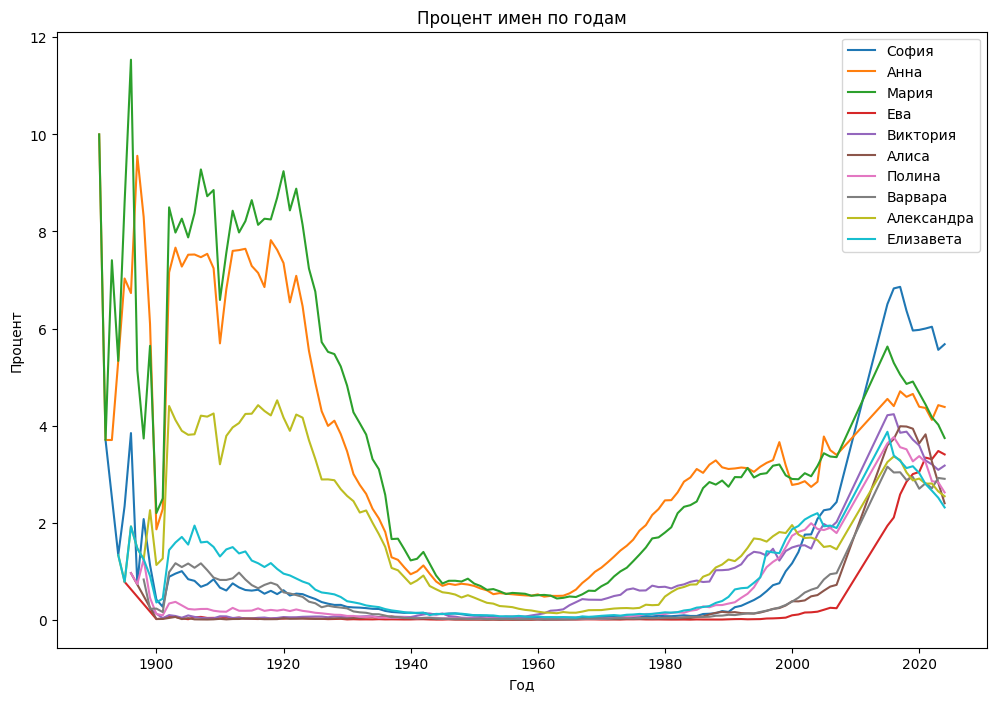

In [137]:
# посмотрим на определенную группу имен - пусть это будет топ-10 самых популярных имен в 2024 году и проверим нашу гипотезу
names_now = list(result_f_dict.values())[-1]

# рисуем график каждого имени
plt.figure(figsize=(12, 8))
for name in names_now:
  df_name = merged_df_female[merged_df_female['name'] == name]
  df_name.loc[:, 'year'] = df_name['year'].astype(int)  # Преобразуем годы в числовой формат
  df_name = df_name.sort_values(by='year')  # Сортируем по году
  plt.plot(df_name['year'], df_name['num'],  linestyle='-', label=name)

plt.xlabel('Год')
plt.ylabel('Процент')
plt.title('Процент имен по годам')
plt.legend()
plt.show()


**Вывод:**

Выше мы можем уидеть прекрасный график, и мы можем заметить, что большинство имен и вправду циклично!

Мы видим, что пик большиснтва имен в 1920 году, потом в 1960 они теряют свою популярность, но к 2000-ным опять возвращают свою популярность. Это отчетливо видно на таких именах, как Анна и Мария.
Например, мою сестру Аню назвали в честь моей прабабушки, вот отличное объяснение этих данных.

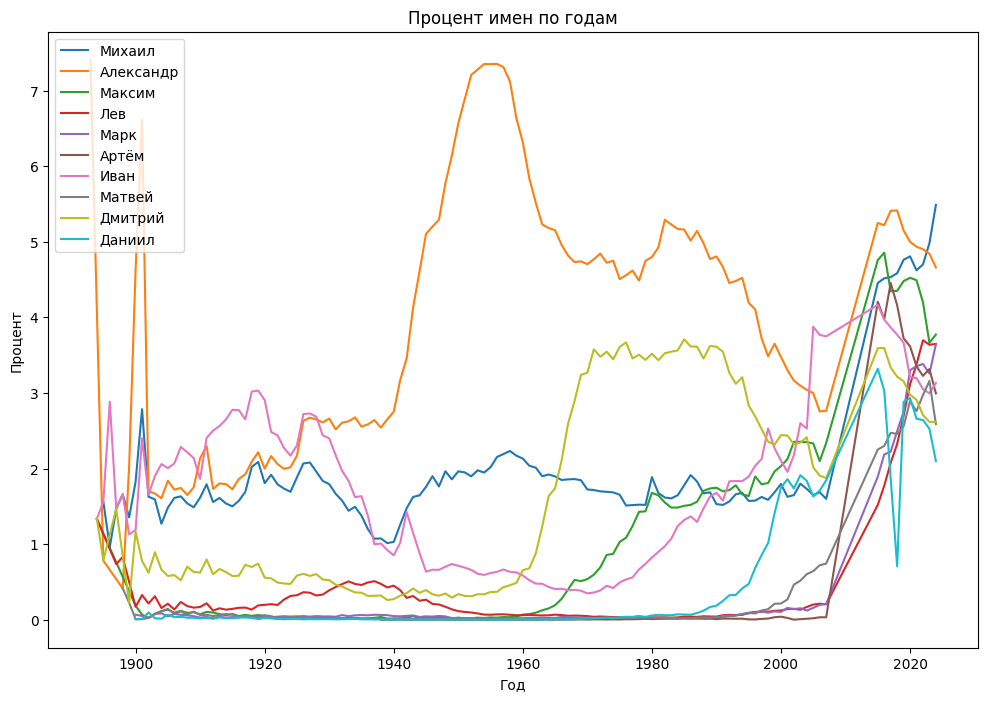

In [138]:
# опять берем самые популярные имена за 2024 год
names_now = list(result_m_dict.values())[-1]

# рисуем график для 10 имен
plt.figure(figsize=(12, 8))
for name in names_now:
  df_name = merged_df_male[merged_df_male['name'] == name]
  df_name.loc[:, 'year'] = df_name['year'].astype(int)  # Преобразуем годы в числовой формат
  df_name = df_name.sort_values(by='year')  # Сортируем по году
  plt.plot(df_name['year'], df_name['num'],  linestyle='-', label=name)

plt.xlabel('Год')
plt.ylabel('Процент')
plt.title('Процент имен по годам')
plt.legend()
plt.show()

Теперь посмотрим на мужские имена - тут все не так очевидно. Но мы можем видеть искомую зависимость у имени Иван и Михаил.

В конце проекта я прикреплю ссылку на Streamlit, чтобы можно было посмотреть на такие графики для всех имен и сделать кое-какие выводы.

### Часть 2.
Теперь посмотрим на разные сайты и проверим информацию, которая там изложена.

**[Первый сайт](https://www.mos.ru/news/item/87520073/)**

Этот сайт говорит, что имя Юрий стало популярно после первого полета в космос Гагарина в 1961 году. Посмотрим на динамику этого имени.

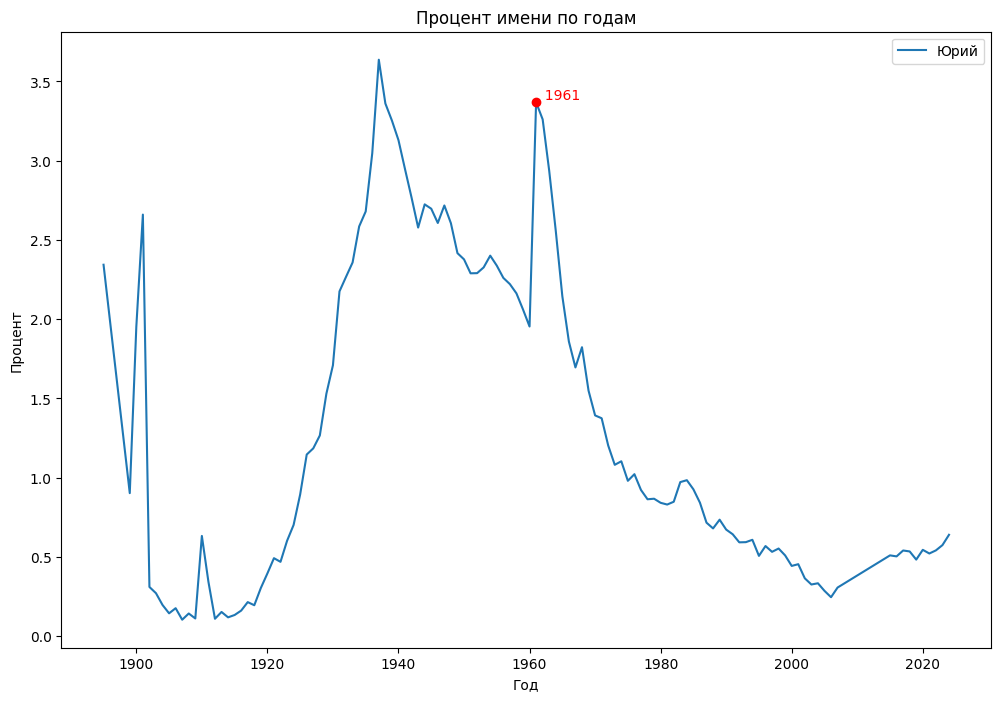

In [139]:
plt.figure(figsize=(12, 8))
name = 'Юрий'

# берем имя и строим для него отдельный график
df_name = merged_df_male[merged_df_male['name'] == name]
df_name.loc[:, 'year']  = df_name['year'].astype(int)
df_name = df_name.sort_values(by='year')  # сортируем по году, а то будет плохо
plt.plot(df_name['year'], df_name['num'],  linestyle='-', label=name)


# ставим точку первого полета в космос
year_1961 =  1961
num_1961 = df_name[df_name['year'] == year_1961]['num'].values[0]  # значение для 1961 года
plt.scatter(year_1961, num_1961, color='red', zorder=5)
plt.text(year_1961, num_1961, '  1961', color='red', verticalalignment='bottom')

plt.xlabel('Год')
plt.ylabel('Процент')
plt.title('Процент имени по годам')
plt.legend()
plt.show()

Действительно, мы видим, что пик имени Юрий приходится на 1961 год! Информация подтверждена.

**[Второй сайт](
https://kto-chto-gde.ru/story/kakie-imena-i-pochemu-byli-populyarny-v-sssr-8-glavnyx-trendov/)**

Сайт пишет, что имя Александра стало очень популярным после выходы фильма "Москва слезам не верит" (1979). Мне это особо инетересно, так как меня саму назвали в честь этого фильма).

А посел фильма "Баллада о солдате" (1959) стало больше Жанн.

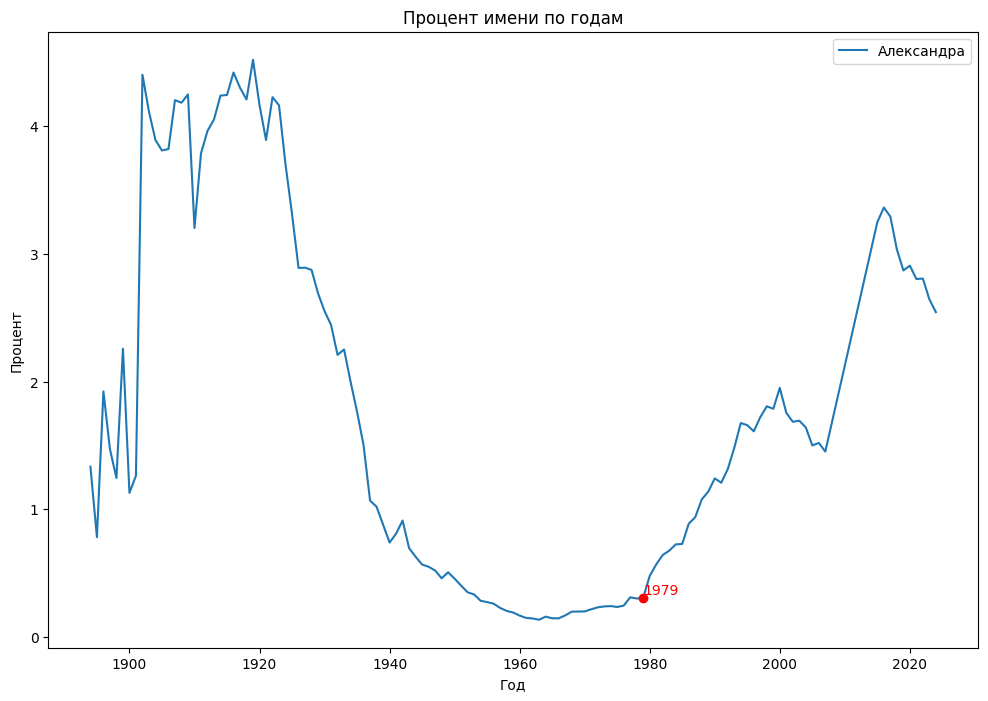

In [140]:
plt.figure(figsize=(12, 8))
name = 'Александра'

# берем имя и строим для него отдельный график

df_name = merged_df_female[merged_df_female['name'] == name]
df_name.loc[:, 'year']  = df_name['year'].astype(int)
df_name = df_name.sort_values(by='year')
plt.plot(df_name['year'], df_name['num'],  linestyle='-', label=name)


# ставим точку даты выхода фильма
year_1979 =  1979
num_1979 = df_name[df_name['year'] == year_1979]['num'].values[0]  # значение для 1979 года
plt.scatter(year_1979, num_1979, color='red', zorder=5)
plt.text(year_1979, num_1979, '1979', color='red', verticalalignment='bottom')

plt.xlabel('Год')
plt.ylabel('Процент')
plt.title('Процент имени по годам')
plt.legend()
plt.show()

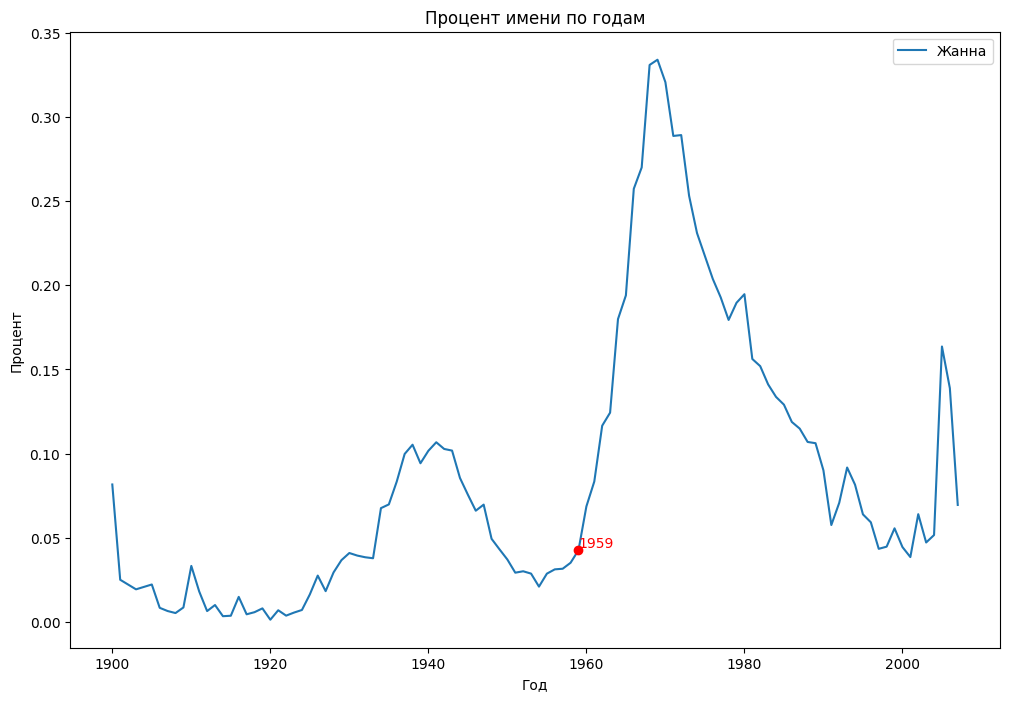

In [141]:
plt.figure(figsize=(12, 8))
name = 'Жанна'

# берем имя и строим для него отдельный график
df_name = merged_df_female[merged_df_female['name'] == name]
df_name.loc[:, 'year']  = df_name['year'].astype(int)
df_name = df_name.sort_values(by='year')  # сортируем по году
plt.plot(df_name['year'], df_name['num'],  linestyle='-', label=name)

# ставим точку выхода фильма
year_1959 =  1959
num_1959 = df_name[df_name['year'] == year_1959]['num'].values[0]  # значение для 1959 года
plt.scatter(year_1959, num_1959, color='red', zorder=5)
plt.text(year_1959, num_1959, '1959', color='red', verticalalignment='bottom')

plt.xlabel('Год')
plt.ylabel('Процент')
plt.title('Процент имени по годам')
plt.legend()
plt.show()

**Вывод:**

Мы видим, что после выхода фильмов имена начинают набирать популярность.

**[Третий сайт](https://www.wday.ru/deti/sovety-roditelyam/teper-ikh-vse-obozhayut-10-imen-kotorye-stali-populyarnymi-blagodarya-filmam/)**

Этот сайт говорит, что имя Данила стало популярным после выхода фильма "Брат" (1997).

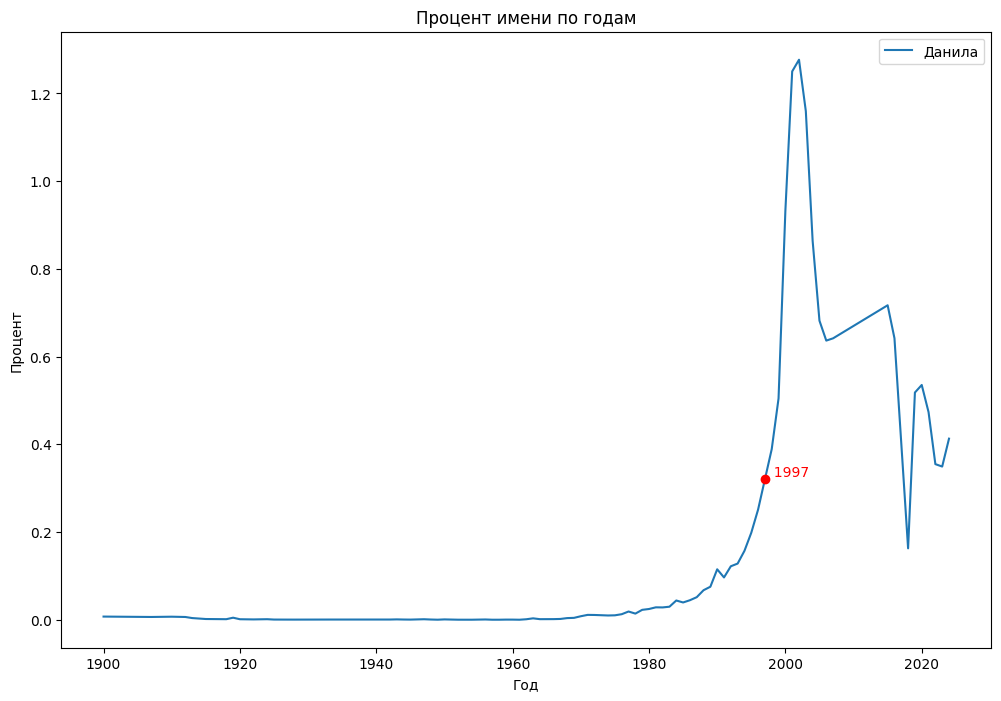

In [142]:
plt.figure(figsize=(12, 8))
name = 'Данила'

# берем имя и строим для него отдельный график
df_name = merged_df_male[merged_df_male['name'] == name]
df_name.loc[:, 'year']  = df_name['year'].astype(int)
df_name = df_name.sort_values(by='year')  # сортируем по году
plt.plot(df_name['year'], df_name['num'],  linestyle='-', label=name)


# ставим точку выхода фильма
year_1997 =  1997
num_1997 = df_name[df_name['year'] == year_1997]['num'].values[0]  # значение для 1997 года
plt.scatter(year_1997, num_1997, color='red', zorder=5)
plt.text(year_1997, num_1997, '  1997', color='red', verticalalignment='bottom')

plt.xlabel('Год')
plt.ylabel('Процент')
plt.title('Процент имени по годам')
plt.legend()
plt.show()

Мы видим, что имя начало набирать популярность до 1997 года, но, вероятно, этот фильм после тоже имел влияние на популярность имени Данила.

## **Шаг 7**

Теперь посмотрим самые популярные имена по регионам [на этом сайте](https://zags.nalog.gov.ru/analytics/names) и выгрузим из него данные.

Хочется построить карту с самыми популярными именами и проверить гипотезу о том, что чем ближе регионы, тем более одинаковые у них популярные имена.

Для этого я использовала репозиторий одного замечательного человека, который уже разбил Россию на регионы и залил это ве на свой [гитхаб](https://github.com/hairymax/offline_russia_plotly/blob/main/data/russia_regions.geojson).

In [143]:
# читаю подгруженные файлы excel
df_regions_w = pd.read_excel('regions_female.xlsx')
df_regions_m = pd.read_excel('regions_male.xlsx')

# можно посмотреть пример данных в них
print(df_regions_w.head())

                  region   name
0         Алтайский край  София
1       Амурская область  София
2  Архангельская область  София
3   Астраханская область  София
4   Белгородская область  София


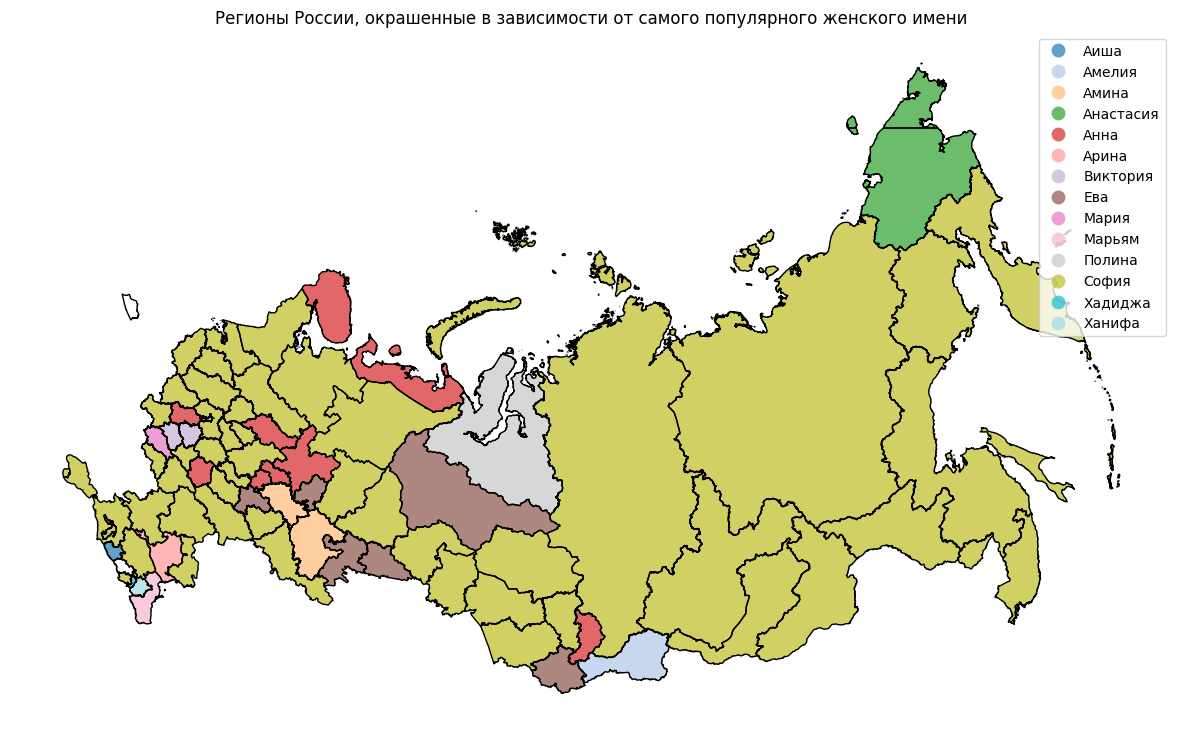

In [144]:
# подгружаем карту России
russia_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
russia_map = russia_map[russia_map['name'] == 'Russia']

# импортируем уже готовую разметку регионов, сделанную одним прекрасным человек
url = "https://raw.githubusercontent.com/hairymax/offline_russia_plotly/main/data/russia_regions.geojson"

# чтение GeoJSON файла
regions_gdf = gpd.read_file(url)

# отделяем часть России, чтобы все выглядело красиво
regions_gdf = regions_gdf.to_crs('EPSG:3576')

# приведение названий регионов к единому формату, чтобы случайно не возникло проблем с соединением таблиц
regions_gdf['region'] = regions_gdf['region'].str.strip()
regions_gdf['region'] = regions_gdf['region'].apply(lambda x: x.lower())
df_regions_w['region'] = df_regions_w['region'].str.strip()
df_regions_w['region'] = df_regions_w['region'].apply(lambda x: x.lower())


# объединение данных по регионам
merged_gdf = regions_gdf.merge(df_regions_w, on='region', how='left')

# рисую карту
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
russia_map.plot(ax=ax, color='lightgrey')
merged_gdf.boundary.plot(ax=ax, linewidth=1, color='k')
merged_gdf.plot(column='name', ax=ax, legend=True, cmap='tab20', alpha = 0.7)
plt.title('Регионы России, окрашенные в зависимости от самого популярного женского имени')
plt.axis('off')
plt.show()

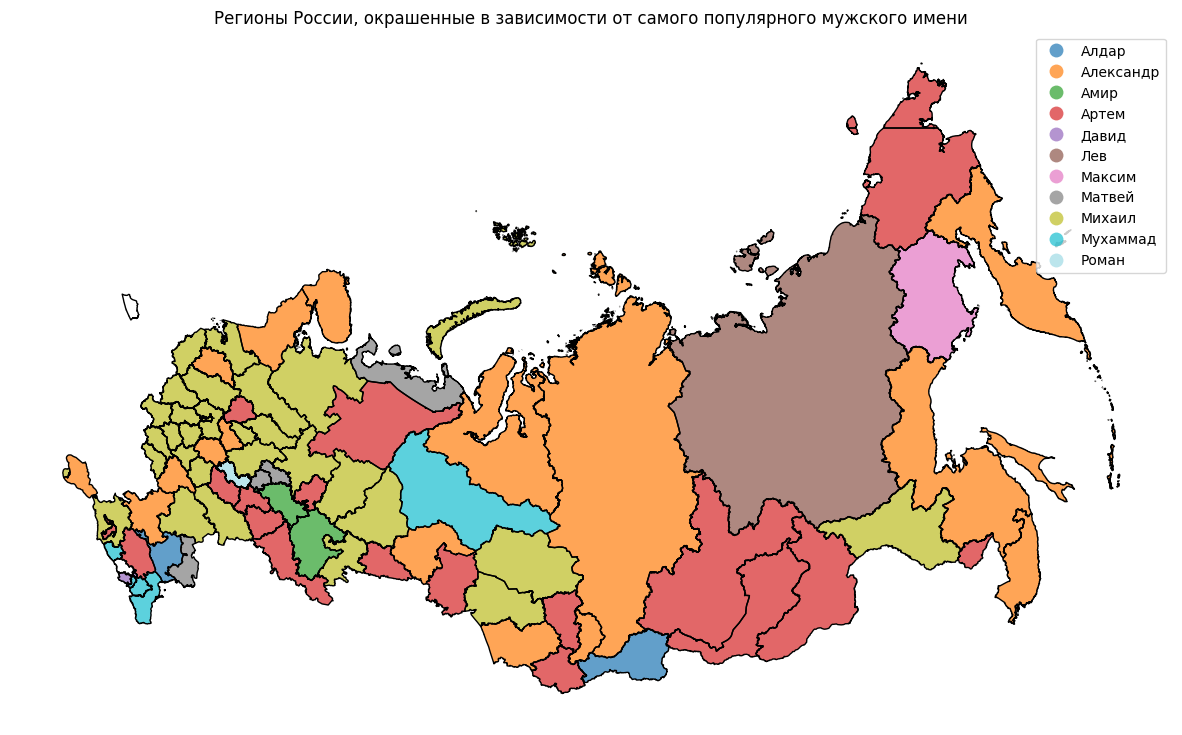

In [145]:
# сделаем такую карту для мужских имен
df_regions_m['region'] = df_regions_m['region'].str.strip()
df_regions_m['region'] = df_regions_m['region'].apply(lambda x: x.lower())
merged_gdf_1 = regions_gdf.merge(df_regions_m, on='region', how='left')

# рисуем карту
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
russia_map.plot(ax=ax, color='lightgrey')
merged_gdf_1.boundary.plot(ax=ax, linewidth=1, color='k')
merged_gdf_1.plot(column='name', ax=ax, legend=True, cmap='tab20', alpha = 0.7)
plt.title('Регионы России, окрашенные в зависимости от самого популярного мужского имени')
plt.axis('off')
plt.show()

Получилась такая красота!

Теперь мы можем увидеть по цветам самые популярные имена в регионах.

Мы можем увидеть, что в основном они расположены "кучками", и редко найдешь регион, который стоит один в своем цвете.

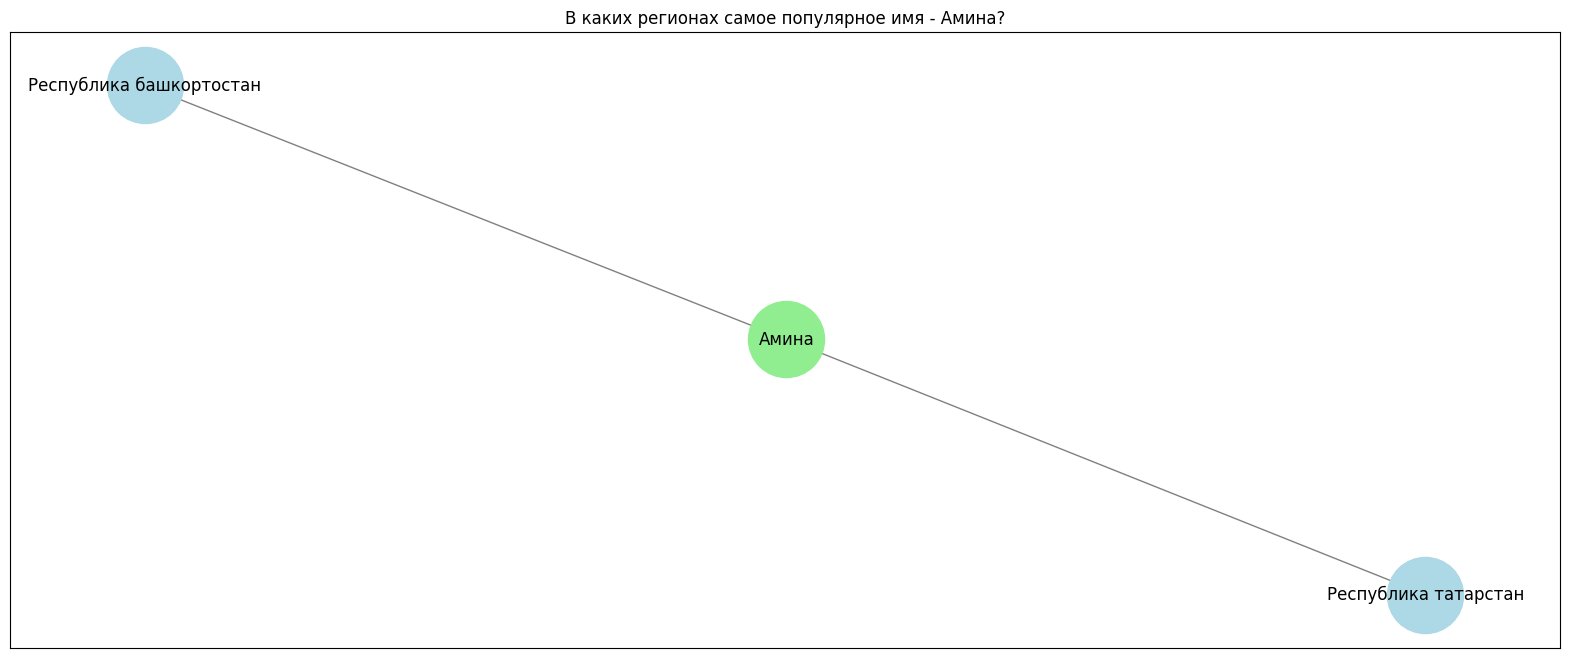

In [146]:
# возьмем для примера имя Амина и посмотрим, какие регионы оно связывает
df_regions_w['region'] = df_regions_w['region'].apply(lambda x: x.capitalize())
df_anna = df_regions_w[df_regions_w['name'] == 'Амина']

# создаем сеть и добавляет узлы и ребра
B = nx.Graph()
for _, row in df_anna.iterrows():
    B.add_node(row['name'], bipartite=0)
    B.add_node(row['region'], bipartite=1)
    B.add_edge(row['name'], row['region'])

pos = nx.spring_layout(B)

# имена
name_nodes = [node for node, data in B.nodes(data=True) if data['bipartite'] == 0]

# регионы
region_nodes = [node for node, data in B.nodes(data=True) if data['bipartite'] == 1]

# рисуем граф
plt.figure(figsize=(20, 8))
nx.draw_networkx_nodes(B, pos, nodelist=name_nodes, node_color='lightgreen', node_size=3000)
nx.draw_networkx_nodes(B, pos, nodelist=region_nodes, node_color='lightblue', node_size=3000)
nx.draw_networkx_edges(B, pos, edgelist=B.edges(), edge_color='gray')
nx.draw_networkx_labels(B, pos, font_size=12, font_family='sans-serif')
plt.title('В каких регионах самое популярное имя - Амина?')
plt.show()


Мы видим, что имя Амина популярно в двух регмонах, которые расположены рядом друг с другом.

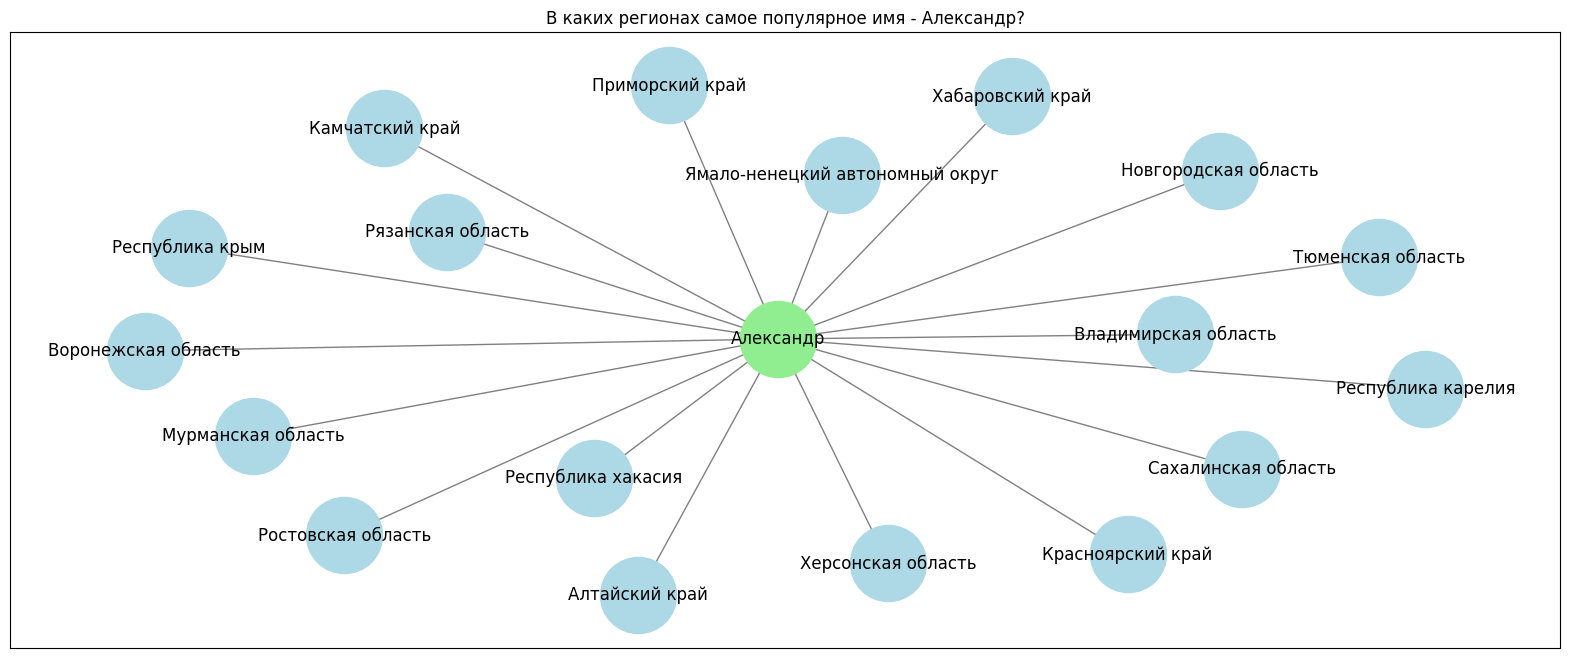

In [147]:
# сделаем такие же действия для мужскиого имени Александр
df_regions_m['region'] = df_regions_m['region'].apply(lambda x: x.capitalize())
df_alex = df_regions_m[df_regions_m['name'] == 'Александр']

# создаем сеть
B = nx.Graph()
for _, row in df_alex.iterrows():
    B.add_node(row['name'], bipartite=0)
    B.add_node(row['region'], bipartite=1)
    B.add_edge(row['name'], row['region'])
pos = nx.spring_layout(B)

# имена
name_nodes = [node for node, data in B.nodes(data=True) if data['bipartite'] == 0]
#  регионы
region_nodes = [node for node, data in B.nodes(data=True) if data['bipartite'] == 1]

# рисуем граф
plt.figure(figsize=(20, 8))
nx.draw_networkx_nodes(B, pos, nodelist=name_nodes, node_color='lightgreen', node_size=3000)
nx.draw_networkx_nodes(B, pos, nodelist=region_nodes, node_color='lightblue', node_size=3000)
nx.draw_networkx_edges(B, pos, edgelist=B.edges(), edge_color='gray')
nx.draw_networkx_labels(B, pos, font_size=12, font_family='sans-serif')
plt.title('В каких регионах самое популярное имя - Александр?')
plt.show()

Мы видим, что имя Александр уже более разбросано по России, но все равно местами "кучкуется".


## **Шаг 8**

Давайте попробуем предсказать, насколько мое имя будет популярно в ближайшие 10 - 13 лет

In [148]:
# я выкидываю 2024 год, потому что он еще не прошел и беру данные только для имени Александра
merged_df_female["year"] = pd.to_numeric(merged_df_female["year"], errors='coerce').fillna(0).astype(int)
merged_df_female = merged_df_female.sort_values(by='year')
merged_df_female = merged_df_female[merged_df_female['year'] != 2024]
name_data = merged_df_female[merged_df_female['name'] == 'Александра']

# делаем модель
x = name_data['year'].values.reshape(-1, 1)  # годы
y = name_data['num'].values.reshape(-1, 1)   # значения

# модель линейной регрессии
model = LinearRegression()
model.fit(x, y)

# предсказание динамики имени "Александра" на следующие несколько лет
future_years = [[year] for year in range(2024, 2036)]
predicted_nums = model.predict(future_years)

# создание data frame для предсказанных значений
predictions_df = pd.DataFrame({
    'name':['Александра','Александра', 'Александра', 'Александра', 'Александра', 'Александра', 'Александра', 'Александра', 'Александра', 'Александра', 'Александра', 'Александра'],
    'year': range(2024, 2036),
    'num': predicted_nums.flatten()  # преобразовываем в одномерный массив
})


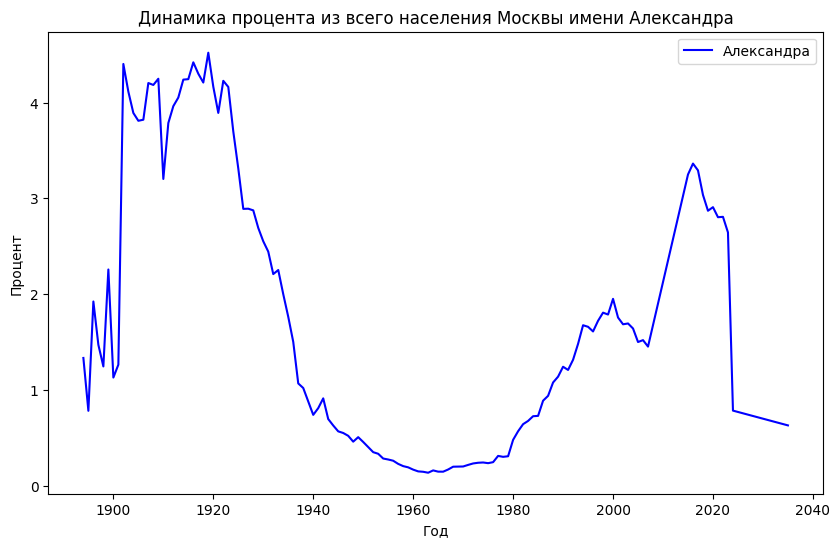

In [149]:
 # построим график, чтобы посмотреть, что предсказала модель
merged_df= pd.concat([name_data, predictions_df], ignore_index=True)
plt.figure(figsize=(10, 6))
plt.plot(merged_df['year'], merged_df['num'], color='blue', label = 'Александра')
plt.title('Динамика процента из всего населения Москвы имени Александра')
plt.xlabel('Год')
plt.ylabel('Процент')
plt.legend()
plt.grid(False)
plt.show()

То есть можно предположить, что имя Александра перестанет быть таким популярным спустя время, и его заменят другие имена. Может быть, хотя бы Саш в будущем будет поменьше, и хотя кому-то будет легче жить (а то мне сейчас тяжеловато).

## **Шаг 9**

Теперь я хочу посмотреть на корреляции имен, популярных в 1960 - 1969 годах и имен и в настоящем. Хочется подтвердить мысль о том, что популярность этих имен очень отрицательно зависит друг от друга.

Также потом интересно будет посмотреть корреляции самых популярных мужских имен в настоящем друг от друга.


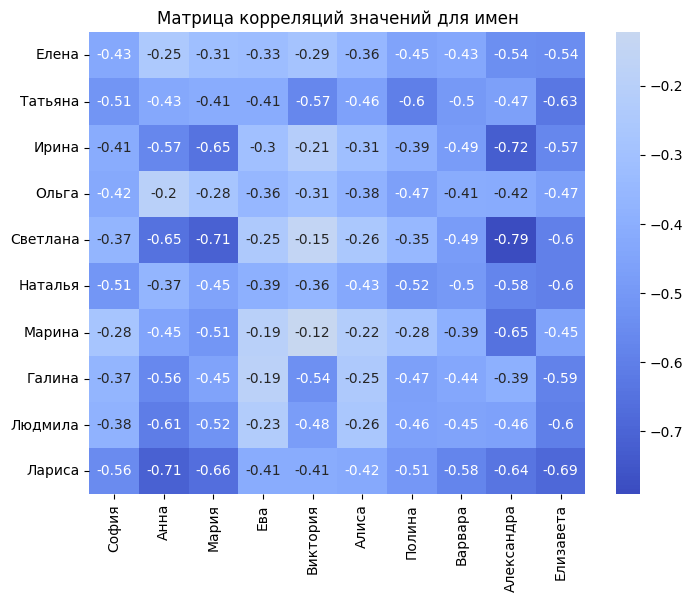

In [150]:
names_past = result_f_dict['1960-1969']
names_current = result_f_dict['2020-2029']

# отбираем данные для нужных нам имен
filtered_df = merged_df_female[merged_df_female['name'].isin(names_past + names_current)]
pivot_df = filtered_df.pivot_table(index='year', columns='name', values='num')

# создаем пустую DataFrame для хранения матрицы корреляций
correlation_matrix = pd.DataFrame(index=names_past, columns=names_current)

# вычисляем корреляции
for name1 in names_past:
    for name2 in names_current:
        series1 = pivot_df[name1].dropna()
        series2 = pivot_df[name2].dropna()
        common_index = series1.index.intersection(series2.index)
        if len(common_index) > 0:
            values1 = series1[common_index].values
            values2 = series2[common_index].values
            if len(values1) > 1 and len(values2) > 1:
                correlation = np.corrcoef(values1, values2)[0, 1]
            else:
                correlation = np.nan
        else:
            correlation = np.nan

        # сохраняем значение корреляции
        correlation_matrix.loc[name1, name2] = correlation

correlation_matrix = correlation_matrix.astype(float)

# рисуем
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций значений для имен')
plt.show()

Тут мы можем везде увидеть отрицательные корелляции, так как люди в настоящем отказываются от более страых имен в пользу новых.

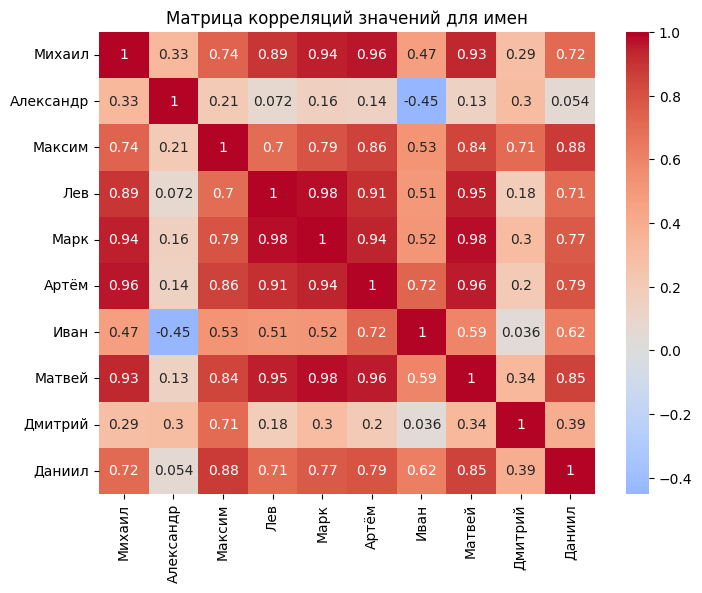

In [152]:
names_current = result_m_dict['2020-2029']

# отбираем данные для нужных нам именnames_current)]
filtered_df = merged_df_male[merged_df_male['name'].isin(names_current)]
pivot_df = filtered_df.pivot_table(index='year', columns='name', values='num')

# создаем пустую DataFrame для хранения матрицы корреляций
correlation_matrix = pd.DataFrame(index=names_current, columns=names_current)

# вычисляем корреляции
for name1 in names_current:
    for name2 in names_current:
        series1 = pivot_df[name1].dropna()
        series2 = pivot_df[name2].dropna()
        common_index = series1.index.intersection(series2.index)
        if len(common_index) > 0:
            values1 = series1[common_index].values
            values2 = series2[common_index].values
            if len(values1) > 1 and len(values2) > 1:
                correlation = np.corrcoef(values1, values2)[0, 1]
            else:
                correlation = np.nan
        else:
            correlation = np.nan

        # сохраняем значение корреляции
        correlation_matrix.loc[name1, name2] = correlation

correlation_matrix = correlation_matrix.astype(float)

# рисуем
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций значений для имен')
plt.show()

Тут можем заметить, что имя Александр слабо коррелирует со всеми, так как даже по графикам я заметила, что оно почти всегда в топе, несмотря на популярность других имен.

А остальные имена довольно сильно зависят друг от друга, что является довольно интересным результатом.

## **Шаг 10**

Теперь посмотрим, насколько Москва следует мировым трендам на имена!

Для этого я нашла [сайт](https://www.ssa.gov/oact/babynames/decades/century.html), который содержит в себе таблицу самых популярных дестких имен за последние 100 лет и считала даннуб таблицу через веб-скреппинг.

Однако данные там были на английском языке, поэтому для того, чтобы соотнести данные из двух таблиц, необходимо было воспользоваться пакетом mtranslate.

In [153]:
# функция для перевода текста
def translate_text(text):
    translated_text = translate(text, 'ru', 'en')
    return translated_text

# URL страницы
url = "https://www.ssa.gov/oact/babynames/decades/century.html"
response = requests.get(url)

# парсим данные и находим таблицу
soup = BeautifulSoup(response.content, 'html.parser')
table = soup.find('table', {'class': 't-stripe'})

# читаем таблицу
html_string = str(table)
df_women_world = pd.read_html(io.StringIO(html_string), header=[0, 1])[0]  # Преобразуем результат в DataFrame

# удаляем последнюю строку, так как она содержит итоги
df_women_world = df_women_world[:-1]
df_women_world.drop(df_women_world.columns[0], axis=1, inplace=True)
df_women_world.columns = ['Males', 'num1', 'Females', 'num2']

# применяем функцию перевода
df_women_world['Males'] = df_women_world['Males'].apply(translate_text)
df_women_world['Females'] = df_women_world['Females'].apply(translate_text)

# посмотрим, что получилось
print(df_women_world.head())


    Males     num1    Females     num2
0  Джеймс  4586625       Мэри  2985148
1   Майкл  4350425   Патрисия  1546373
2  Роберт  4305346  Дженнифер  1470260
3    Джон  4304850      Линда  1448217
4  Дэйвид  3563511   Элизабет  1395049


In [154]:
# берем топ 100 имен в Москве за все года
top_names = merged_df_female.groupby('name')['num'].sum().reset_index().sort_values(by='num', ascending=False)
popular_names_now = list(top_names.head(100)['name'])

# если имя находится в мировых трендах, то добавляем его в список
trends = []
for name in popular_names_now:
  if name in list(df_women_world['Females']):
    trends.append(name)

print('Женские имена в России, которые популярны во всем мире:', ', '.join(trends))

Женские имена в России, которые популярны во всем мире: Мария, Анна, Екатерина, София, Юлия, Виктория, Алиса, Кристина, Диана


Мы видим, что 9 женских имен в Москве находятся в мировых трендах!

## **Шаг 11**

Теперь интересно, у какого имени был самый большой скачок и самое большое падение в популярности. Найдем такие имена.

Для этого используем SQL, так как требуется довольно большой запрос.

In [157]:
# подключаемся к базе данных
conn = sqlite3.connect('names_analysis.db')

# записываем DataFrame в базу данных
merged_df_female.to_sql('name_popularity', conn, if_exists='replace', index=False)

# выполняем запрос SQL
query = """
    WITH name_changes AS (
        SELECT
            name,
            year,
            num - LAG(num) OVER (PARTITION BY name ORDER BY year) AS popularity_change
        FROM
            name_popularity
    )
    SELECT
        name,
        year,
        popularity_change
    FROM
        name_changes
    WHERE
        popularity_change IS NOT NULL
"""

# читаем результат запроса в data frame
result_df = pd.read_sql_query(query, conn)

# нахождение строки с наибольшим значением popularity_change
max_popularity_change = result_df.loc[result_df['popularity_change'].idxmax()]
print("Строка с наибольшим значением popularity_change:")
print(max_popularity_change)

# нахождение строки с наименьшим значением popularity_change
min_popularity_change = result_df.loc[result_df['popularity_change'].idxmin()]
print("\nСтрока с наименьшим значением popularity_change:")
print(min_popularity_change)

# закрываем соединение с базой данных
conn.close()


Строка с наибольшим значением popularity_change:
name                    Мария
year                     1902
popularity_change    5.995843
Name: 43574, dtype: object

Строка с наименьшим значением popularity_change:
name                 Екатерина
year                      1894
popularity_change    -8.666667
Name: 23576, dtype: object


Мы видим, что наибольший скачок был у имени Мария, а наибольший спад у имени Екатерина.

## **Шаг 12**

Теперь интерактивная часть - можно потыкаться в streamlit, и посомотреть на динамику интересующих имен. Вот ссылка на streamlit, размещенная в открытом доступе в интернете: https://namesapp-jf3vn50k74.streamlit.app/

Если интересно, то можно проверить еще некоторые гипотезы по популярности имен  с сайтов, которые я нашла: [первый](https://aif.ru/society/people/ot_ivana_do_artyoma_kakie_imena_byli_populyarny_v_rossii_v_raznye_gody), [второй](https://deti.mail.ru/article/zhenskie-imena-kotorye-voshli-v-modu-blagodarya-pe/).

*Если совершенно случайно ссылка решит не работать, то решение ниже!*

Но если работает, то лучше не смотреть код ниже - это одно и то же, просто создает временную ссылку (только его надо открыть в Google Collab!!!, при этом подгрузив файлы w.xlsx и m.xlsx)

Как работать с ngrok читала [здесь](https://blog.jcharistech.com/2020/08/16/how-to-run-streamlit-apps-from-googles-colab/).

In [109]:
%%writefile app.py
import pandas as pd
import matplotlib.pyplot as plt
import streamlit as st
def main():
    # тут просто копирую код из шага 6 и адаптирую его под streamlit
    url = "https://raw.githubusercontent.com/meule/names/master/names.csv"

    # таблица 1
    df = pd.read_csv(url)
    df['num'] = df['num'] / df['total']*100
    df.drop('total', axis=1, inplace=True)
    df_female = df[df['sex'] == 'Ж'].copy()
    df_male = df[df['sex'] == 'М'].copy()
    df_female.drop('sex', axis=1, inplace=True)
    df_male.drop('sex', axis=1, inplace=True)

     # таблица 2
    df_women = pd.read_excel('w.xlsx')
    df_m = pd.read_excel('m.xlsx')
    df_women = df_women.drop(index=0).reset_index(drop=True)
    df_m = df_m.drop(index=0).reset_index(drop=True)
    df_women["NumberOfPersons"] = pd.to_numeric(df_women["NumberOfPersons"], errors='coerce').fillna(0).astype(int)

    # найдем количество имен для каждого года
    names_per_year = df_women.groupby("Year")["NumberOfPersons"].sum().reset_index()
    names_per_year.columns = ["year", "count_names"]

    # группируем данные по имени и году
    df_sumf = df_women.groupby(["Name", "Year"])["NumberOfPersons"].sum().reset_index()
    df_sumf.columns = ['name', 'year', 'num']

    # объединяем
    df_sumf = pd.merge(df_sumf, names_per_year, on='year')

    # проценты
    df_sumf['num'] = df_sumf['num'] / df_sumf['count_names']*100
    df_sumf.drop('count_names', axis=1, inplace=True)

    # то же самое для мужчин
    df_m["NumberOfPersons"] = pd.to_numeric(df_m["NumberOfPersons"], errors='coerce').fillna(0).astype(int)
    names_per_year = df_m.groupby("Year")["NumberOfPersons"].sum().reset_index()
    names_per_year.columns = ["year", "count_names"]
    df_summ = df_m.groupby(["Name", "Year"])["NumberOfPersons"].sum().reset_index()
    df_summ.columns = ['name', 'year', 'num']
    df_summ = pd.merge(df_summ, names_per_year, on='year')
    df_summ['num'] = df_summ['num'] / df_summ['count_names']*100
    df_summ.drop('count_names', axis=1, inplace=True)

    # соединяем таблицы для женщин
    merged_df_female = pd.concat([df_female, df_sumf], ignore_index=True)
    merged_df_female['name'] = merged_df_female['name'].apply(lambda x: x.capitalize() if x.isupper() else x.lower().capitalize())
    merged_df_female['name'] = merged_df_female['name'].replace('София, софья', 'София')
    merged_df_female['name'] = merged_df_female['name'].replace('Софья', 'София')
    merged_df_female = merged_df_female.groupby(['name', 'year'], as_index=False).agg({'num': 'sum'})

    # соединяем для мужчин
    merged_df_male = pd.concat([df_male, df_summ], ignore_index=True)
    merged_df_male['name'] = merged_df_male['name'].apply(lambda x: x.capitalize() if x.isupper() else x.lower().capitalize())
    merged_df_male['name'] = merged_df_male['name'].replace('Аарон', 'Арон')
    merged_df_male = merged_df_male.groupby(['name', 'year'], as_index=False).agg({'num': 'sum'})

    # Streamlit
    st.title('Процент имени по годам')

    # выбор имени для женщин
    name_female = st.selectbox('Выберите имя для женщин', merged_df_female['name'].unique())

    # фильтрация данных по имени для женщин
    df_name_female = merged_df_female[merged_df_female['name'] == name_female]
    df_name_female.loc[:, 'year'] = df_name_female['year'].astype(int)
    df_name_female = df_name_female.sort_values(by='year')

    # построение графика для женщин
    fig_female, ax_female = plt.subplots(figsize=(12, 8))
    ax_female.plot(df_name_female['year'], df_name_female['num'], linestyle='-', label=name_female)
    ax_female.set_xlabel('Год')
    ax_female.set_ylabel('Процент')
    ax_female.set_title('Процент имени по годам (Женщины)')
    ax_female.legend()

    # выбор имени для мужчин
    name_male = st.selectbox('Выберите имя для мужчин', merged_df_male['name'].unique())

    # фильтрация данных по имени для мужчин
    df_name_male = merged_df_male[merged_df_male['name'] == name_male]
    df_name_male.loc[:, 'year'] = df_name_male['year'].astype(int)  # Преобразуем годы в числовой формат
    df_name_male = df_name_male.sort_values(by='year')  # Сортируем по году

    # построение графика для мужчин
    fig_male, ax_male = plt.subplots(figsize=(12, 8))
    ax_male.plot(df_name_male['year'], df_name_male['num'], linestyle='-', label=name_male)
    ax_male.set_xlabel('Год')
    ax_male.set_ylabel('Процент')
    ax_male.set_title('Процент имени по годам (Мужчины)')
    ax_male.legend()

    # Отображение графиков в Streamlit
    st.pyplot(fig_female)
    st.pyplot(fig_male)

if __name__ == "__main__":
    main()


Writing app.py


In [110]:
ngrok.kill()

In [114]:
!ngrok authtoken 2hYIpQLfFYBAVIaHW333ytGy3UM_4r9J3HRaqcpwsesgUPAfM

Authtoken saved to configuration file: C:\Users\Win 10\AppData\Local/ngrok/ngrok.yml


In [ ]:
!streamlit run app.py &>/dev/null&

In [90]:
!kill 74771

In [96]:
!pgrep streamlit

74799
75307


In [97]:
# запускаю Streamlit
command = ['streamlit', 'run', 'app.py', '--server.port', '8501']
process = subprocess.Popen(command)

# жду некоторое время, чтобы сервер успел запуститься - а то он часто тормозит
time.sleep(5)

# создаю публичный URL через Ngrok
public_url = ngrok.connect(8501)
print(f"Public URL: {public_url}")

Public URL: NgrokTunnel: "https://1d51-34-69-145-226.ngrok-free.app" -> "http://localhost:8501"


## **Шаг 13**

Можно выдохнуть и успокоиться!!!